In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, brier_score_loss, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve


from sklearn.metrics import f1_score
import os
import matplotlib.pyplot as plt
#from sklearn.metrics import plot_roc_curve

from pathlib import Path

In [3]:
def get_clean_data():
  parent = Path(__name__).parent.parent.parent
  #filename = os.path.join(parent, "data", "data.csv")
  data_path = '../data/data.csv'
  data = pd.read_csv(data_path)

  data['gender'] = data['gender'].map({ 'Male': 0, 'Female': 1})

  smoker_converted=pd.get_dummies(data['smoking_history'],drop_first=True)
  data=pd.concat([data,smoker_converted],axis=1)
  data.drop('smoking_history',axis=1,inplace=True)

  data['never'] = data.apply(lambda row: row['never'] + row['ever'], axis=1)
  data.drop(['ever'], axis=1, inplace=True)

  data = data.rename(columns={'not current': 'not_current'})
  data["former"] = data["not_current"] + data["former"]
  data.drop(['not_current'], axis=1, inplace=True)

  data = data.dropna()
  
  return data

In [14]:
data = get_clean_data()

X = data.drop(['diabetes'], axis=1)
y = data['diabetes']
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1111, random_state=42, stratify=y_train_val)
print(len(X_train))
print(len(y_train))


79985
79985


In [8]:
def create_model(data): 
  X = data.drop(['diabetes'], axis=1)
  y = data['diabetes']
  
  # scale the data
  scaler = StandardScaler()
  X = scaler.fit_transform(X)
  
  # split the data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=420)
  
  # train the model

  params = {
    'n_estimators': 100,
    'max_depth': 3,
    'learning_rate': 0.1,
    'random_state': 420
  }

  model = GradientBoostingClassifier(**params)
  model.fit(X_train, y_train)
  
  
  # test model

  y_pred = model.predict(X_test)
  
  f1 = f1_score(y_test, y_pred)
  print("F1 score:", f1)

  print("Accuracy of our model: ", accuracy_score(y_test, y_pred))
  print("Classification report: \n", classification_report(y_test, y_pred))
  
  return model, scaler

In [65]:
def create_model(data): 
  X = data.drop(['diabetes'], axis=1)
  y = data['diabetes']
  
  # scale the data
  scaler = StandardScaler()
  X = scaler.fit_transform(X)
  
  # split the data
  X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=16, stratify=y)

  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1111, random_state=16, stratify=y_train_val)
  
  # train the model

  params = {
    'n_estimators': 100,
    'max_depth': 3,
    'learning_rate': 0.1,
    'random_state': 420
  }

  gb_model = GradientBoostingClassifier(**params)
  gb_model.fit(X_train, y_train)
  
  #####################################################################################################


  y_pred = gb_model.predict(X_val)

  acc = accuracy_score(y_val, y_pred)
  bs = brier_score_loss(y_val, y_pred)
  
  print(f"Validation Accuracy: {acc:.3f}")
  print(f"Validation Brier Score: {bs:.3f}")

  #####################################################################################################

  #y_probab = gb_model.predict_proba(X_test)[:, 1]

# Get the true probabilities and the average predicted probabilities
  #true_prob, pred_prob = calibration_curve(y_test, y_probab, n_bins=10)

  # Plot the calibration curve
  # fig, ax = plt.subplots()
  # ax.plot([0, 1], [0, 1], linestyle='--')
  # ax.plot(pred_prob, true_prob, marker='.')
  # ax.set_xlabel('Predicted probability')
  # ax.set_ylabel('True probability')
  # ax.set_title('Calibration Curve')
  # plt.show()

  calibrated_model = CalibratedClassifierCV(gb_model, cv='prefit', method ='isotonic')
  calibrated_model.fit(X_val, y_val)
  
  y_pred_calibrated = calibrated_model.predict(X_test)
  acc_calibrated = accuracy_score(y_test, y_pred_calibrated)
  bs_calibrated = brier_score_loss(y_test, y_pred_calibrated)

  print(f"Calibrated Test Accuracy: {acc_calibrated:.3f}")
  print(f"Calibrated Test Brier: {bs_calibrated:.3f}")
  

  #y_proba = calibrated_model.predict_proba(X_test)[:, 1]

# Get the true probabilities and the average predicted probabilities
  #true_prob, pred_prob = calibration_curve(y_test, y_proba, n_bins=10)

  # Plot the calibration curve
  # fig, ax = plt.subplots()
  # ax.plot([0, 1], [0, 1], linestyle='--')
  # ax.plot(pred_prob, true_prob, marker='.')
  # ax.set_xlabel('Predicted probability')
  # ax.set_ylabel('True probability')
  # ax.set_title('Calibration Curve')
  # plt.show()

  #return calibrated_model

  fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#
  # Plot the uncalibrated model
  prob_pos = gb_model.predict_proba(X_test)[:, 1]
  fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
  ax.plot(mean_predicted_value, fraction_of_positives, 's-', label='Uncalibrated')

  bs_uncalibrated= mean_absolute_error(fraction_of_positives, mean_predicted_value)
  print(bs_uncalibrated)

  # Plot the calibrated model
  prob_pos_calibrated = calibrated_model.predict_proba(X_test)[:, 1]
  fraction_of_positives_calibrated, mean_predicted_value_calibrated = calibration_curve(y_test, prob_pos_calibrated, n_bins=10)
  ax.plot(mean_predicted_value_calibrated, fraction_of_positives_calibrated, 's-', label='Calibrated')

  bs_calibrated = mean_absolute_error(fraction_of_positives_calibrated, mean_predicted_value_calibrated)
  print(bs_calibrated)

  # Plot the reference line
  ax.plot([0, 1], [0, 1], '--', color='gray', label='Reference')

  # Set the axis labels and legend
  ax.set_xlabel('Mean predicted value')
  ax.set_ylabel('Fraction of positives')
  ax.set_ylim([-0.05, 1.05])
  ax.legend()

  plt.show()

  

#, scaler

Validation Accuracy: 0.972
Validation Brier Score: 0.028
Calibrated Test Accuracy: 0.970
Calibrated Test Brier: 0.030
0.14026367246607718
0.03502063489803152


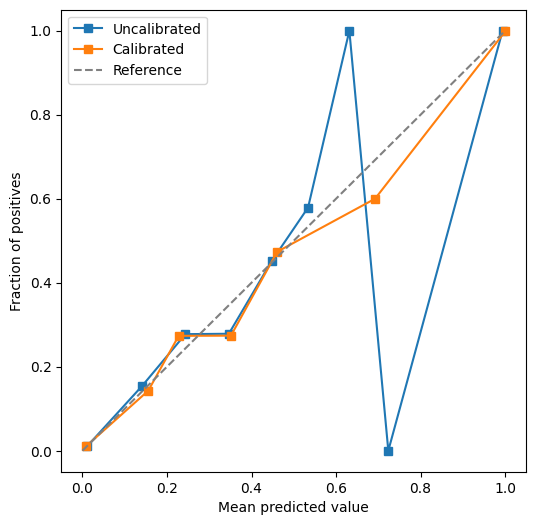

In [66]:
create_model(data)

In [7]:
def create_model_2(data): 
  X = data.drop(['diabetes'], axis=1)
  y = data['diabetes']
  
  # scale the data
  scaler = StandardScaler()
  X = scaler.fit_transform(X)
  
  # split the data 80/10/10 train/validation/test
  X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=16, stratify=y
    )

  X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1111, random_state=16, stratify=y_train_val
    )
  
  # train and fit the gbx model

  params = {
    'n_estimators': 100,
    'max_depth': 3,
    'learning_rate': 0.1,
    'random_state': 420
  }

  clf = GradientBoostingClassifier(**params)
  clf.fit(X_train, y_train)

  # test the gbx model
  y_pred = clf.predict(X_val)

  acc = accuracy_score(y_val, y_pred)

  prob_pos = clf.predict_proba(X_test)[:, 1]
  fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
  uncalibrated_mae = mean_absolute_error(fraction_of_positives, mean_predicted_value)

  print(f"Validation Accuracy: {acc:.3f}")
  print(f"Validation Calibration Curve MAE: {uncalibrated_mae:.3f}")

  # train and fit calibration model

  calibrated_model = CalibratedClassifierCV(clf, cv='prefit', method ='isotonic')
  calibrated_model.fit(X_val, y_val)
  
  # test the calibration model
  y_pred_calibrated = calibrated_model.predict(X_test)

  acc_calibrated = accuracy_score(y_test, y_pred_calibrated)

  prob_pos_calibrated = calibrated_model.predict_proba(X_test)[:, 1]
  fraction_of_positives_calibrated, mean_predicted_value_calibrated = calibration_curve(y_test, prob_pos_calibrated, n_bins=10)
  calibrated_mae = mean_absolute_error(fraction_of_positives_calibrated, mean_predicted_value_calibrated)

  print(f"Test Accuracy: {acc_calibrated:.3f}")
  print(f"Test Calibration Curve MAE Score: {calibrated_mae:.3f}")

  return calibrated_model, scaler

In [8]:
data = get_clean_data()
create_model_2(data)

Validation Accuracy: 0.972
Validation Calibration Curve MAE: 0.140
Test Accuracy: 0.970
Test Calibration Curve MAE Score: 0.035


(CalibratedClassifierCV(cv='prefit',
                        estimator=GradientBoostingClassifier(random_state=420),
                        method='isotonic'),
 StandardScaler())

In [ ]:
create_model(data)

In [13]:
# Define the parameter grids for each model
def mega_grid_search(data):

    models=[]

    X = data.drop(['diabetes'], axis=1)
    y = data['diabetes']
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    lr_params = {
        'penalty': ['l1', 'l2'], 
        'C': [0.1, 1, 10]
    }

    rf_params = {
        'n_estimators': [50, 100, 150], 
        'max_depth': [3, 5, 7]
    }

    dt_params = {
        'max_depth': [2, 4, 6],
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [5, 10, 15]
    }

    gbc_params = {
        #'n_estimators': [100], #50 100 150
        #'learning_rate': [0.1], #0.2 0.3
        #'max_depth': [3, 4, 5]
    }

    # Create a list of tuples containing the models and their respective parameter grids
    models_and_params = [
    (LogisticRegression(), lr_params), 
    (DecisionTreeClassifier(), dt_params),
    (GradientBoostingClassifier(), gbc_params)
    ]

    #(RandomForestClassifier(), rf_params),
                        
    #models_and_params = [(GradientBoostingClassifier(), gbc_params)]

    # Iterate over the models and parameter grids
    for model, params in models_and_params:
        # Create a GridSearchCV object with the current model and parameter grid
        grid = GridSearchCV(model, params, cv=5, scoring='f1')
        
        # Fit the GridSearchCV object to the data
        grid.fit(X, y)
        
        # Print the best parameters and score
        print(f"Best parameters for {type(model).__name__}: {grid.best_params_}")
        print(f"Best {grid.scoring} score: {grid.best_score_:.4f}")
        best_params = grid.best_params_
        model.set_params(**best_params)
        models.append(model)

    return models


In [14]:
grid = mega_grid_search(data)

#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
#https://medium.com/@aleemuddin13/how-to-host-static-website-on-firebase-hosting-for-free-9de8917bebf2 

/Users/michal/opt/anaconda3/envs/stat/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michal/opt/anaconda3/envs/stat/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michal/opt/anaconda3/envs/stat/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/michal/opt/anaconda3/envs/stat/lib/python3.9/site-packag

Best parameters for LogisticRegression: {'C': 1, 'penalty': 'l2'}
Best f1 score: 0.7294
Best parameters for DecisionTreeClassifier: {'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 5}
Best f1 score: 0.8016
Best parameters for GradientBoostingClassifier: {}
Best f1 score: 0.8060


NameError: name 'grid' is not defined

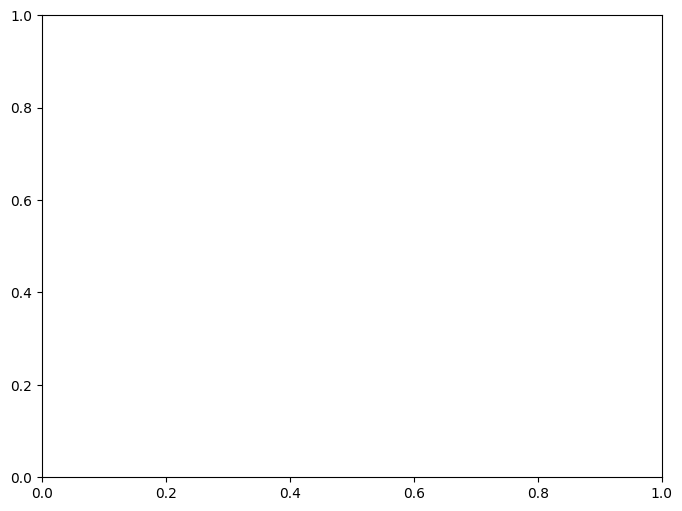

In [31]:
# assume 'grid' is the GridSearchCV object that you have fitted on your data
X = data.drop(['diabetes'], axis=1)
y = data['diabetes']
  
  # scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=420
  )

fig, ax = plt.subplots(figsize=(8, 6))
for model in grid:
    name = str(model.__class__.__name__)
    plot_roc_curve(model, X_test, y_test, name=name, ax=ax)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', c='r')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.title('ROC Curves for Iterated Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

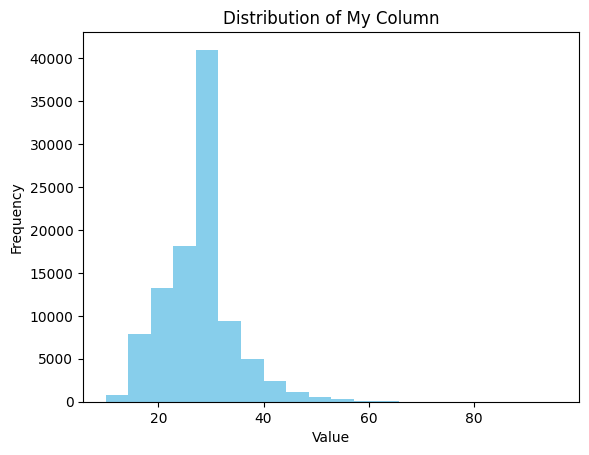

In [33]:
plt.hist(data["bmi"], bins=20, color="skyblue")
plt.title("Distribution of My Column")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [37]:
len(data)

99982

In [38]:
clf = IsolationForest(contamination=0.05, random_state=42)
clf.fit(data)

# Use the trained model to predict whether each sample is an outlier
is_outlier = clf.predict(data)

# Select only the non-outliers from the data
X_clean = data[is_outlier == 1]

/Users/michal/Library/Caches/pypoetry/virtualenvs/diabetes-ml-jIUNA_Nw-py3.8/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [6]:
data["diabetes"].value_counts()

0    91482
1     8500
Name: diabetes, dtype: int64